In [5]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from collections import Counter
import matplotlib.pyplot as plt


# Carregar os arquivos
train_df = pd.read_csv('C:\\Users\\Carlos Moura\\Desktop\\Modelos\\train.csv')
test_df = pd.read_csv('C:\\Users\\Carlos Moura\\Desktop\\Modelos\\test.csv')

# Definir o limite de 50% para exclusão de colunas
threshold = 0.5

# Remover colunas com mais de 50% de valores ausentes em ambos os datasets
train_df = train_df.loc[:, train_df.isnull().mean() <= threshold]

# Alinhar as colunas entre treino e teste (manter apenas colunas comuns)
common_columns = train_df.columns.intersection(test_df.columns)
train_df = train_df[common_columns]
test_df = test_df[common_columns]

# Calcular a mediana das colunas do conjunto de treino
train_medians = train_df.median()

# Preencher os valores ausentes no conjunto de treino usando a mediana calculada
train_df.fillna(train_medians, inplace=True)

# Preencher os valores ausentes no conjunto de teste usando a mediana do conjunto de treino
test_df.fillna(train_medians, inplace=True)

# Função para substituir outliers pela mediana
def replace_outliers_with_median(df, lower_quantile=0.25, upper_quantile=0.75, factor=1.5):
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        median = df[col].median()
        
        # Substituir os valores que estão fora dos limites pelo valor da mediana
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])
    return df

# Aplicar a função de substituição dos outliers nos dados de treino e teste
X_train = replace_outliers_with_median(train_df.drop('y', axis=1))
y_train = train_df['y']
X_test = replace_outliers_with_median(test_df.drop('y', axis=1))
y_test = test_df['y']

# Escalonar os dados usando StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter os arrays escalonados de volta para DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [6]:
# Selecionar 10% dos dados de treino mantendo a proporção das classes na coluna 'y'
X_train_scaled, _, y_train, _ = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.9,  # Retém 10% dos dados
    stratify=y_train,  # Mantém a proporção das classes em 'y_train'
    random_state=42
)

# Exibir o número de amostras em cada conjunto e a distribuição das classes
print("Amostra de treino - Distribuição de classes:")
print(y_train.value_counts(normalize=True))

Amostra de treino - Distribuição de classes:
1    0.856213
0    0.143787
Name: y, dtype: float64



Relatório de classificação para kernel RBF com C=1 e gamma=scale:
              precision    recall  f1-score   support

           0       0.49      0.87      0.62      2186
           1       0.97      0.85      0.91     13017

    accuracy                           0.85     15203
   macro avg       0.73      0.86      0.76     15203
weighted avg       0.90      0.85      0.87     15203


Matriz de confusão para kernel RBF com C=1 e gamma=scale:
[[ 1893   293]
 [ 2001 11016]]

AUC ROC Score para kernel RBF com C=1 e gamma=scale: 0.93


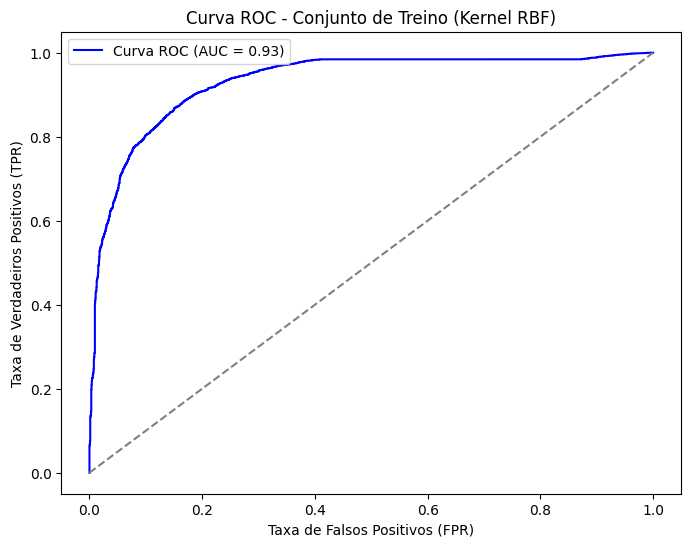

In [7]:
# Hiperparâmetros
C_value = 1  
gamma_value = 'scale'

# Treinamento do SVM com kernel RBF e ajuste de peso das classes
svm_rbf = SVC(kernel='rbf', C=C_value, gamma=gamma_value, class_weight='balanced', probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train.values.ravel())

# Fazer previsões no conjunto de treino
y_pred_rbf = svm_rbf.predict(X_train_scaled)
y_train_proba = svm_rbf.predict_proba(X_train_scaled)[:, 1]  # Probabilidades da classe positiva

# Avaliar o desempenho do modelo com kernel RBF e ajuste de peso
print(f"\nRelatório de classificação para kernel RBF com C={C_value} e gamma={gamma_value}:")
print(classification_report(y_train, y_pred_rbf))

# Matriz de confusão
print(f"\nMatriz de confusão para kernel RBF com C={C_value} e gamma={gamma_value}:")
print(confusion_matrix(y_train, y_pred_rbf))

# Calcular o AUC ROC
roc_auc = roc_auc_score(y_train, y_train_proba)
print(f"\nAUC ROC Score para kernel RBF com C={C_value} e gamma={gamma_value}: {roc_auc:.2f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Treino (Kernel RBF)")
plt.legend()
plt.show()


Relatório de classificação para kernel RBF no conjunto de teste com C=1 e gamma=scale:
              precision    recall  f1-score   support

           0       0.30      0.65      0.41      2388
           1       0.85      0.57      0.68      8358

    accuracy                           0.59     10746
   macro avg       0.58      0.61      0.55     10746
weighted avg       0.73      0.59      0.62     10746


Matriz de confusão para kernel RBF no conjunto de teste com C=1 e gamma=scale:
[[1561  827]
 [3598 4760]]

AUC ROC Score para kernel RBF no conjunto de teste com C=1 e gamma=scale: 0.66


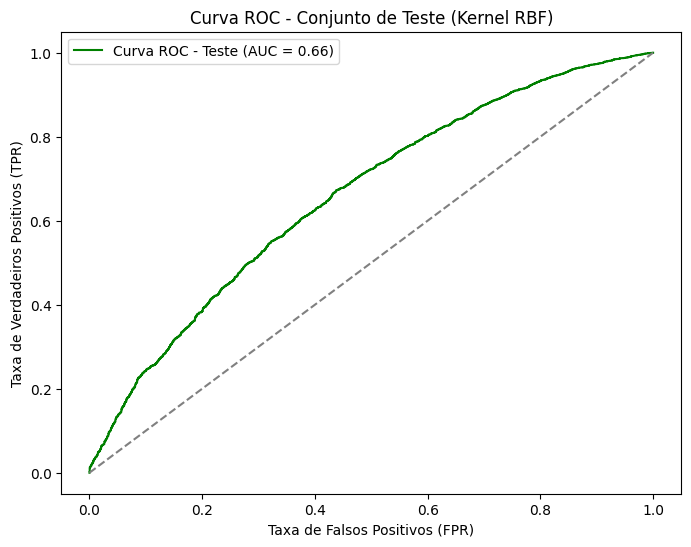

In [8]:
# Fazer previsões no conjunto de teste
y_test_pred = svm_rbf.predict(X_test_scaled)
y_test_proba = svm_rbf.predict_proba(X_test_scaled)[:, 1]  # Probabilidades da classe positiva

# Avaliar o desempenho do modelo com kernel RBF no conjunto de teste
print(f"\nRelatório de classificação para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusão no conjunto de teste
print(f"\nMatriz de confusão para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}:")
print(confusion_matrix(y_test, y_test_pred))

# Calcular o AUC ROC no conjunto de teste
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC ROC Score para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}: {roc_auc_test:.2f}")

# Curva ROC no conjunto de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Curva ROC - Teste (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Teste (Kernel RBF)")
plt.legend()
plt.show()


Relatório de classificação para kernel RBF com C=10 e gamma=0.01:
              precision    recall  f1-score   support

           0       0.64      0.94      0.77      2186
           1       0.99      0.91      0.95     13017

    accuracy                           0.92     15203
   macro avg       0.82      0.93      0.86     15203
weighted avg       0.94      0.92      0.92     15203


Matriz de confusão para kernel RBF com C=10 e gamma=0.01:
[[ 2064   122]
 [ 1137 11880]]

AUC ROC Score para kernel RBF com C=10 e gamma=0.01: 0.98


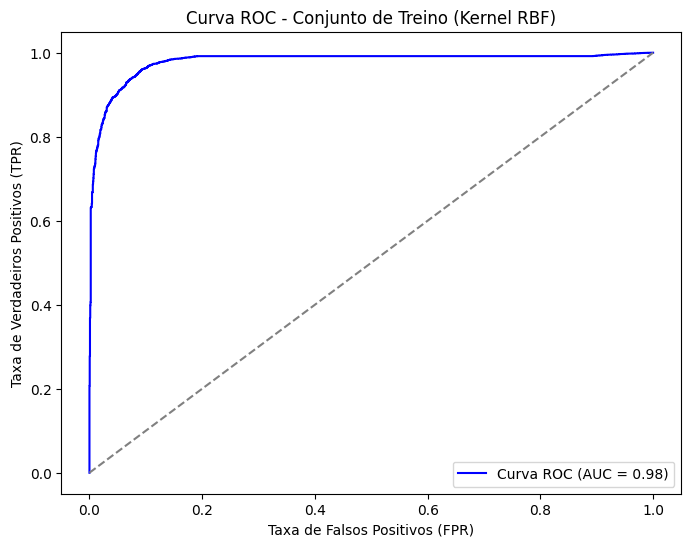

In [10]:
# Definir o valor de C e gamma
C_value = 10
gamma_value = 0.01

# Treinamento do SVM com kernel RBF e ajuste de peso das classes
svm_rbf = SVC(kernel='rbf', C=C_value, gamma=gamma_value, class_weight='balanced', probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train.values.ravel())

# Fazer previsões no conjunto de treino
y_pred_rbf = svm_rbf.predict(X_train_scaled)
y_train_proba = svm_rbf.predict_proba(X_train_scaled)[:, 1]  # Probabilidades da classe positiva

# Avaliar o desempenho do modelo com kernel RBF e ajuste de peso
print(f"\nRelatório de classificação para kernel RBF com C={C_value} e gamma={gamma_value}:")
print(classification_report(y_train, y_pred_rbf))

# Matriz de confusão
print(f"\nMatriz de confusão para kernel RBF com C={C_value} e gamma={gamma_value}:")
print(confusion_matrix(y_train, y_pred_rbf))

# Calcular o AUC ROC
roc_auc = roc_auc_score(y_train, y_train_proba)
print(f"\nAUC ROC Score para kernel RBF com C={C_value} e gamma={gamma_value}: {roc_auc:.2f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Treino (Kernel RBF)")
plt.legend()
plt.show()




Relatório de classificação para kernel RBF no conjunto de teste com C=10 e gamma=0.01:
              precision    recall  f1-score   support

           0       0.31      0.48      0.38      2388
           1       0.82      0.69      0.75      8358

    accuracy                           0.65     10746
   macro avg       0.57      0.59      0.57     10746
weighted avg       0.71      0.65      0.67     10746


Matriz de confusão para kernel RBF no conjunto de teste com C=10 e gamma=0.01:
[[1156 1232]
 [2550 5808]]

AUC ROC Score para kernel RBF no conjunto de teste com C=10 e gamma=0.01: 0.62


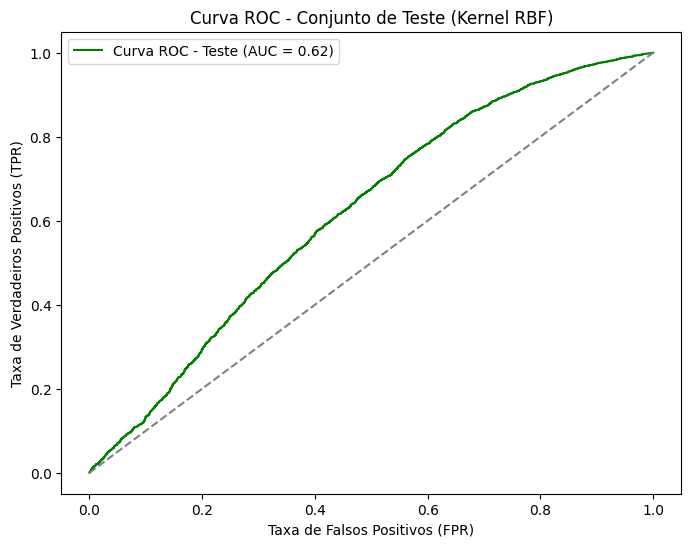

In [11]:
# Fazer previsões no conjunto de teste
y_test_pred = svm_rbf.predict(X_test_scaled)
y_test_proba = svm_rbf.predict_proba(X_test_scaled)[:, 1]  # Probabilidades da classe positiva

# Avaliar o desempenho do modelo com kernel RBF no conjunto de teste
print(f"\nRelatório de classificação para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusão no conjunto de teste
print(f"\nMatriz de confusão para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}:")
print(confusion_matrix(y_test, y_test_pred))

# Calcular o AUC ROC no conjunto de teste
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC ROC Score para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}: {roc_auc_test:.2f}")

# Curva ROC no conjunto de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Curva ROC - Teste (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Teste (Kernel RBF)")
plt.legend()
plt.show()



Relatório de classificação para kernel RBF com C=5 e gamma=0.001:
              precision    recall  f1-score   support

           0       0.30      0.63      0.40      2186
           1       0.92      0.75      0.83     13017

    accuracy                           0.73     15203
   macro avg       0.61      0.69      0.62     15203
weighted avg       0.83      0.73      0.77     15203


Matriz de confusão para kernel RBF com C=5 e gamma=0.001:
[[1378  808]
 [3260 9757]]

AUC ROC Score para kernel RBF com C=5 e gamma=0.001: 0.75


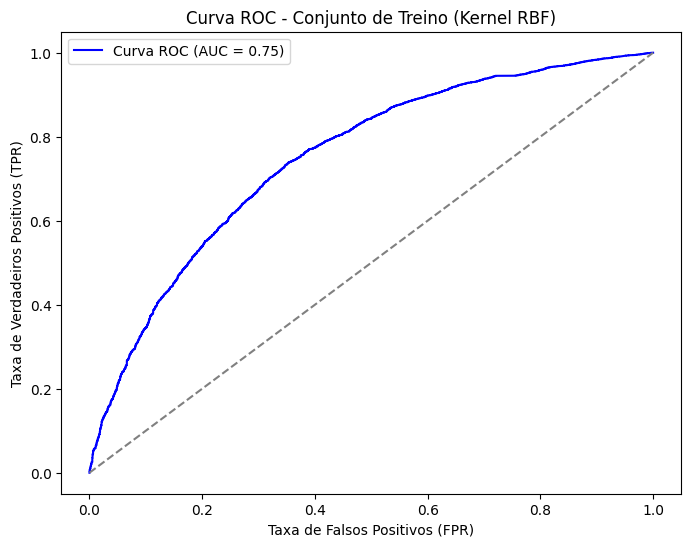

In [12]:
# Definir o valor de C e gamma
C_value = 5
gamma_value = 0.001

# Treinamento do SVM com kernel RBF e ajuste de peso das classes
svm_rbf = SVC(kernel='rbf', C=C_value, gamma=gamma_value, class_weight='balanced', probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train.values.ravel())

# Fazer previsões no conjunto de treino
y_pred_rbf = svm_rbf.predict(X_train_scaled)
y_train_proba = svm_rbf.predict_proba(X_train_scaled)[:, 1]  # Probabilidades da classe positiva

# Avaliar o desempenho do modelo com kernel RBF e ajuste de peso
print(f"\nRelatório de classificação para kernel RBF com C={C_value} e gamma={gamma_value}:")
print(classification_report(y_train, y_pred_rbf))

# Matriz de confusão
print(f"\nMatriz de confusão para kernel RBF com C={C_value} e gamma={gamma_value}:")
print(confusion_matrix(y_train, y_pred_rbf))

# Calcular o AUC ROC
roc_auc = roc_auc_score(y_train, y_train_proba)
print(f"\nAUC ROC Score para kernel RBF com C={C_value} e gamma={gamma_value}: {roc_auc:.2f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Treino (Kernel RBF)")
plt.legend()
plt.show()


Relatório de classificação para kernel RBF no conjunto de teste com C=5 e gamma=0.001:
              precision    recall  f1-score   support

           0       0.27      0.84      0.41      2388
           1       0.88      0.35      0.50      8358

    accuracy                           0.46     10746
   macro avg       0.58      0.60      0.46     10746
weighted avg       0.75      0.46      0.48     10746


Matriz de confusão para kernel RBF no conjunto de teste com C=5 e gamma=0.001:
[[2004  384]
 [5407 2951]]

AUC ROC Score para kernel RBF no conjunto de teste com C=5 e gamma=0.001: 0.69


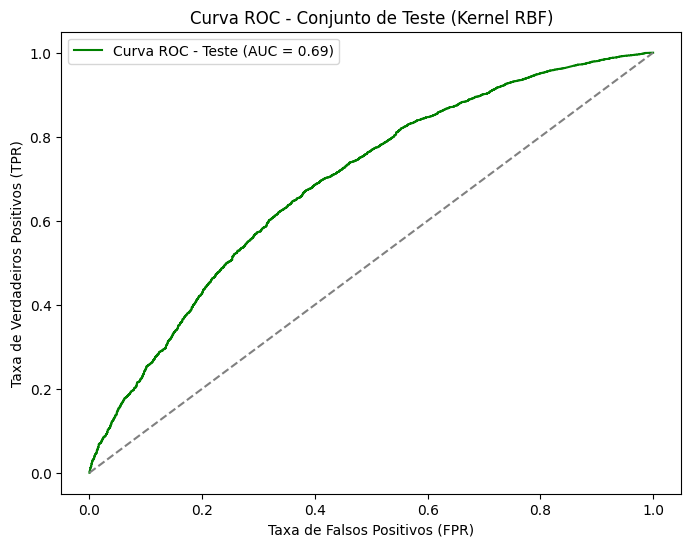

In [13]:
# Fazer previsões no conjunto de teste
y_test_pred = svm_rbf.predict(X_test_scaled)
y_test_proba = svm_rbf.predict_proba(X_test_scaled)[:, 1]  # Probabilidades da classe positiva

# Avaliar o desempenho do modelo com kernel RBF no conjunto de teste
print(f"\nRelatório de classificação para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusão no conjunto de teste
print(f"\nMatriz de confusão para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}:")
print(confusion_matrix(y_test, y_test_pred))

# Calcular o AUC ROC no conjunto de teste
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC ROC Score para kernel RBF no conjunto de teste com C={C_value} e gamma={gamma_value}: {roc_auc_test:.2f}")

# Curva ROC no conjunto de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Curva ROC - Teste (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Teste (Kernel RBF)")
plt.legend()
plt.show()


In [ ]:

# Definir o grid de parâmetros para C e gamma
param_grid = {
    'C': [1, 5, 10, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale', 'auto']
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=42), 
                           param_grid, 
                           cv=3,  # Validação cruzada com 3 dobras
                           scoring='f1_weighted',  # Avaliar com base no F1-score ponderado
                           verbose=3)

# Executar o Grid Search com os dados de treino
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Exibir os melhores parâmetros encontrados pelo Grid Search
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Fazer previsões com o melhor modelo
y_pred_best = grid_search.best_estimator_.predict(X_train_scaled)

# Avaliar o desempenho do melhor modelo
print(f"\nRelatório de classificação para o melhor modelo encontrado pelo Grid Search:")
print(classification_report(y_train, y_pred_best))

# Matriz de confusão
print(f"\nMatriz de confusão para o melhor modelo encontrado pelo Grid Search:")
print(confusion_matrix(y_train, y_pred_best))


In [ ]:
# Aplicar o SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verificar a nova distribuição das classes após SMOTE
print(f"Distribuição após o SMOTE: {Counter(y_train_balanced)}")

# Treinar o SVM com kernel RBF no dataset balanceado
svm_rbf = SVC(kernel='rbf', C=10, gamma='auto', class_weight='balanced', random_state=42)
svm_rbf.fit(X_train_balanced, y_train_balanced)

# Fazer previsões no conjunto de treino balanceado
y_pred_rbf = svm_rbf.predict(X_train_balanced)

# Avaliar o desempenho
print("\nRelatório de classificação com SMOTE e kernel RBF:")
print(classification_report(y_train_balanced, y_pred_rbf))

# Matriz de confusão
print("\nMatriz de confusão com SMOTE e kernel RBF:")
print(confusion_matrix(y_train_balanced, y_pred_rbf))


In [ ]:
# Aplicar o SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verificar a nova distribuição das classes após SMOTE
print(f"Distribuição após o SMOTE: {Counter(y_train_balanced)}")

# Definir o grid de parâmetros para C e gamma
param_grid = {
    'C': [1, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=42), 
                           param_grid, 
                           cv=5,  # Validação cruzada com 5 dobras
                           scoring='f1_weighted',  # Avaliar com base no F1-score ponderado
                           verbose=3)

# Executar o Grid Search com os dados balanceados
grid_search.fit(X_train_balanced, y_train_balanced)

# Exibir os melhores parâmetros encontrados pelo Grid Search
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Fazer previsões com o melhor modelo encontrado
y_pred_best = grid_search.best_estimator_.predict(X_train_balanced)

# Avaliar o desempenho do melhor modelo
print("\nRelatório de classificação para o melhor modelo encontrado pelo Grid Search:")
print(classification_report(y_train_balanced, y_pred_best))

# Matriz de confusão
print("\nMatriz de confusão para o melhor modelo encontrado pelo Grid Search:")
print(confusion_matrix(y_train_balanced, y_pred_best))


In [ ]:
# Aplicar o SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verificar a nova distribuição das classes após SMOTE
print(f"Distribuição após o SMOTE: {Counter(y_train_balanced)}")

# Treinar o SVM com os parâmetros encontrados (C=10, gamma='auto')
svm_rbf = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=42)
svm_rbf.fit(X_train_balanced, y_train_balanced)

# Fazer previsões no conjunto de treino balanceado
y_pred_train = svm_rbf.predict(X_train_balanced)

# Avaliar o desempenho do modelo
print("\nRelatório de classificação com C=10 e gamma='auto':")
print(classification_report(y_train_balanced, y_pred_train))

# Matriz de confusão
print("\nMatriz de confusão com C=10 e gamma='auto':")
print(confusion_matrix(y_train_balanced, y_pred_train))
